# Investigating perplexity scores for promoter regions using varying promoter extraction techniques

In [62]:
import Bio
from Bio import SeqIO, SeqFeature
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random; random.seed(0)
import seaborn as sns

## Genbank files and general genome info

In [2]:
# 5GB1c genome (Methylomicrobium buryatense from Mitch)
gbFile_5G = 'data/5GB1c.current.gb'

# E. coli genome (https://www.ncbi.nlm.nih.gov/nuccore/NC_000913.2)
gbFile_ecoli = 'data/ecoli_k12_NC_000913.2.gb'

In [3]:
gb_5G = SeqIO.parse(gbFile_5G, "genbank").__next__()
gb_ecoli = SeqIO.parse(gbFile_ecoli, "genbank").__next__()

print("___ 5G ____")
print("Genome length:", len(gb_5G.seq), "bps")
print("num features:", len(gb_5G.features))
print("num CDS features:", len([x for x in gb_5G.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_5G.features if x.type=='gene']))

print("\n___ Ecoli ____")
print("Genome length:", len(gb_ecoli.seq), "bps")
print("num features:", len(gb_ecoli.features))
print("num CDS features:", len([x for x in gb_ecoli.features if x.type=='CDS']))
print("num gene features:", len([x for x in gb_ecoli.features if x.type=='gene']))

___ 5G ____
Genome length: 4998879 bps
num features: 8863
num CDS features: 4369
num gene features: 4427

___ Ecoli ____
Genome length: 4639675 bps
num features: 9913
num CDS features: 4321
num gene features: 4497


In [4]:
# a sampling of genbank features
for x in gb_5G.features[:5]:
    print(x)
    
for x in gb_ecoli.features[:5]:
    print(x)

type: source
location: [0:4998879](+)
qualifiers:
    Key: collection_date, Value: ['1999-01']
    Key: country, Value: ['Russia: Transbaikal']
    Key: db_xref, Value: ['taxon:95641']
    Key: isolation_source, Value: ['Soda lake sediment']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Methylomicrobium buryatense']
    Key: strain, Value: ['5GB1C']

type: gene
location: [0:1317](+)
qualifiers:
    Key: gene, Value: ['dnaA']
    Key: locus_tag, Value: ['EQU24_00005']

type: CDS
location: [0:1317](+)
qualifiers:
    Key: codon_start, Value: ['1']
    Key: gene, Value: ['dnaA']
    Key: inference, Value: ['COORDINATES: similar to AA sequence:RefSeq:WP_006891211.1']
    Key: locus_tag, Value: ['EQU24_00005']
    Key: note, Value: ['Derived by automated computational analysis using gene prediction method: Protein Homology.']
    Key: product, Value: ['chromosomal replication initiator protein DnaA']
    Key: protein_id, Value: ['PRJNA515283:EQU24_00005']
    Key: tr

## CDS processing

In [5]:
def get_cds_coords(seq_record):
    '''
    Given a SeqRecord parsed from a genbank file, return a list of 
    all the CDS start/end coordinates and gene/locus names
    '''
    cds_list = []
    # Loop over the genome CDS features on each of the strands
    for feature in seq_record.features:
        if feature.type == 'CDS':
            # get  locus tag and gene name
            lt = feature.qualifiers['locus_tag'][0]
            g = "" if 'gene' not in feature.qualifiers else feature.qualifiers['gene'][0]
            
            cds_list.append((feature.location.start.position,
                             feature.location.end.position,
                             feature.strand,
                             lt,
                             g))
    return cds_list

In [6]:
cds_5G = get_cds_coords(gb_5G)
print(cds_5G[:10])
print()

cds_ecoli = get_cds_coords(gb_ecoli)
print(cds_ecoli[:10])

[(0, 1317, 1, 'EQU24_00005', 'dnaA'), (1502, 2603, 1, 'EQU24_00010', ''), (3060, 4140, 1, 'EQU24_00015', 'recF'), (4185, 6600, 1, 'EQU24_00020', 'gyrB'), (6825, 7062, 1, 'EQU24_00025', ''), (7098, 7257, 1, 'EQU24_00030', ''), (7350, 7734, 1, 'EQU24_00035', ''), (7818, 9075, 1, 'EQU24_00040', ''), (9071, 10241, 1, 'EQU24_00045', ''), (10240, 13306, 1, 'EQU24_00050', '')]

[(189, 255, 1, 'b0001', 'thrL'), (336, 2799, 1, 'b0002', 'thrA'), (2800, 3733, 1, 'b0003', 'thrB'), (3733, 5020, 1, 'b0004', 'thrC'), (5233, 5530, 1, 'b0005', 'yaaX'), (5682, 6459, -1, 'b0006', 'yaaA'), (6528, 7959, -1, 'b0007', 'yaaJ'), (8237, 9191, 1, 'b0008', 'talB'), (9305, 9893, 1, 'b0009', 'mog'), (9927, 10494, -1, 'b0010', 'yaaH')]


### Check that all the features in the CDS lists are indeed ordered

In [7]:
# 5G start coordinates and genome locus tags
starts = [x[0] for x in cds_5G]
print(starts == sorted(starts))
loci = [x[3].split('_')[1] for x in cds_5G]
print(loci == sorted(loci))

print()

# E coli start coordinates and genome locus tags
starts = [x[0] for x in cds_ecoli]
print(starts == sorted(starts))
loci = [x[3][1:] for x in cds_ecoli]
print(loci == sorted(loci))

True
True

True
False


In [9]:
# Seems like some ecoli genes were added between others after the fact (like hokC)... 
# probs ok...?
cds_ecoli[:20]

[(189, 255, 1, 'b0001', 'thrL'),
 (336, 2799, 1, 'b0002', 'thrA'),
 (2800, 3733, 1, 'b0003', 'thrB'),
 (3733, 5020, 1, 'b0004', 'thrC'),
 (5233, 5530, 1, 'b0005', 'yaaX'),
 (5682, 6459, -1, 'b0006', 'yaaA'),
 (6528, 7959, -1, 'b0007', 'yaaJ'),
 (8237, 9191, 1, 'b0008', 'talB'),
 (9305, 9893, 1, 'b0009', 'mog'),
 (9927, 10494, -1, 'b0010', 'yaaH'),
 (10642, 11356, -1, 'b0011', 'yaaW'),
 (11381, 11786, -1, 'b0013', 'yaaI'),
 (12162, 14079, 1, 'b0014', 'dnaK'),
 (14167, 15298, 1, 'b0015', 'dnaJ'),
 (15444, 16557, 1, 'b0016', 'insL1'),
 (16750, 16960, -1, 'b0018', 'mokC'),
 (16750, 16903, -1, 'b4412', 'hokC'),
 (17488, 18655, 1, 'b0019', 'nhaA'),
 (18714, 19620, 1, 'b0020', 'nhaR'),
 (19810, 20314, -1, 'b0021', 'insB1')]

### Quick plots to see CDS distribution

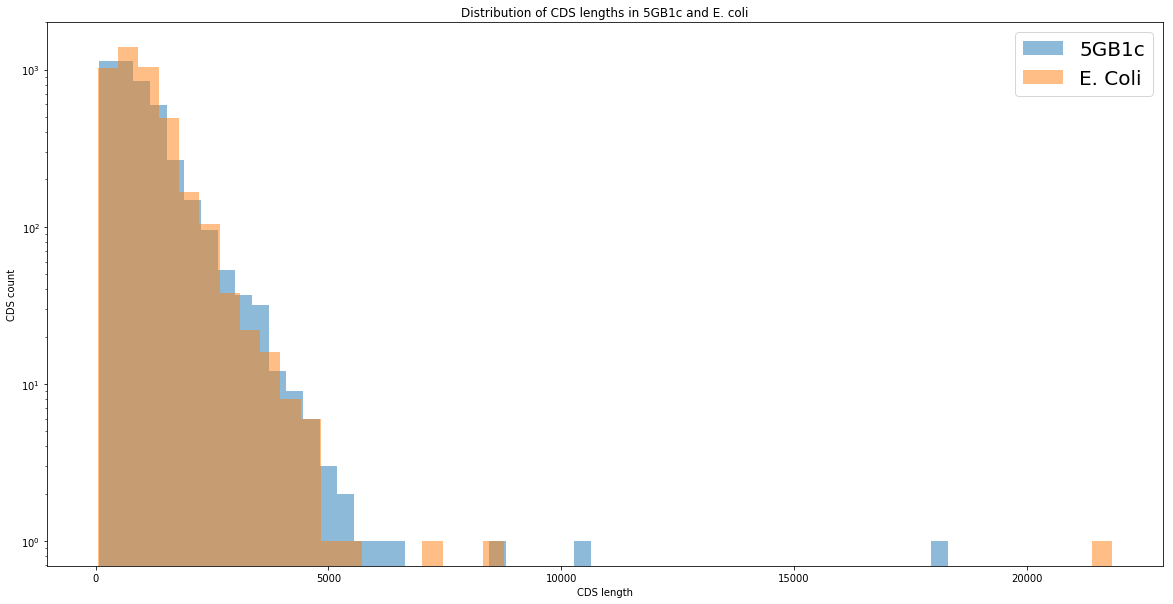

In [11]:
cds_5G_lengths = [e-s for (s,e,_,_,_) in cds_5G]
cds_ecoli_lengths = [e-s for (s,e,_,_,_) in cds_ecoli]

plt.figure(figsize=(20,10))
plt.hist(cds_5G_lengths, alpha = 0.5, bins=50, label='5GB1c')
plt.hist(cds_ecoli_lengths, alpha = 0.5, bins=50, label='E. Coli')
plt.yscale('log')
plt.xlabel("CDS length")
plt.ylabel("CDS count")
plt.title("Distribution of CDS lengths in 5GB1c and E. coli")
plt.legend(fontsize = 20)
plt.show()

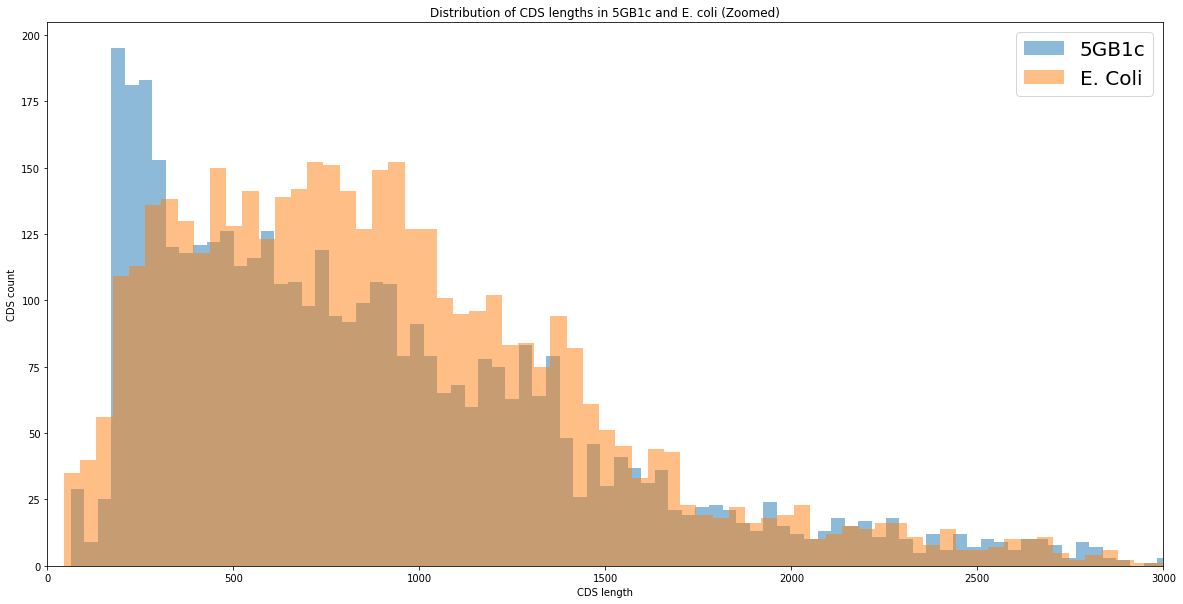

In [12]:
plt.figure(figsize=(20,10))
plt.hist(cds_5G_lengths, alpha = 0.5, bins=500, label='5GB1c')
plt.hist(cds_ecoli_lengths, alpha = 0.5, bins=500, label='E. Coli')

#plt.yscale('log')
plt.xlabel("CDS length")
plt.ylabel("CDS count")
plt.title("Distribution of CDS lengths in 5GB1c and E. coli (Zoomed)")
plt.xlim(0,3000)
plt.legend(fontsize = 20)
plt.show()

### Gene locus look up dict

In [157]:
def get_locus_gene_lookup(cds_list):
    '''
    Given a list of CDSs with locus tag and gene info, return a dict mapping
    locus tag to gene name
    '''
    locus_gene_lookup = {}
    gene_locus_lookup = {}
    # loop through the CDS list and make a look up of locus to gene
    for x in cds_list:
        if x[4]== '':
            # if the gene name is empty, just use the locus tag
            locus_gene_lookup[x[3]] = x[3]
        # otherwise use the gene name
        else:
            locus_gene_lookup[x[3]] = x[4]
            gene_locus_lookup[x[4]] = x[3]

    return locus_gene_lookup, gene_locus_lookup

locus_gene_lookup_5G, gene_locus_lookup_5G = get_locus_gene_lookup(cds_5G)
locus_gene_lookup_ecoli, gene_locus_lookup_ecoli = get_locus_gene_lookup(cds_ecoli)

# Promoter Extraction

In [191]:
def get_promoters(gb_record, 
                  cds_list, 
                  promoter_window = 300,
                  operon_mode = False, 
                  min_gene_distance=40):
    '''
    Given a list of CDSs with (LEFT, RIGHT, STRAND, locus, gene),
    loop through and collect their promoters by getting the 300 bp
    upstream of the start codon. If in operon conscious mode, ignore 
    regions that fall within min_gene_distance bp of another gene. 
    (Won't exhaustively consider all operons but a quick-n-dirty start)
    
    Args:
      * promoter_window: how far upstream of a gene should we extract a promoter region?
      * operon_mode: When True, it will ignore upstream regions which are "too close" to the 
          current gene (aka within min_gene_distance of the start codon)
      * min_gene_distance: min distance required between the current gene and its 
          upstream neighbor otherwise we flag it as a potential operon
    '''
    promoters = [] # promoter sequence and genes they belong to
    candidate_operon_genes = [] # gene pairings that are potentially in the same operon
    operon_locs = [] # mid point in intergenic distance between two genes which have been 
                     # flagged as potentially in an operon
    
    # loop through all CDSs
    for i,(g_left,g_right,strand,locus,gene) in enumerate(cds_list):
        # keep track of whether or not to skip operon
        operon_skip_flag = False
        
        gene_string = "%s|%s" % (locus, gene)
        
        # +-----------------+
        # | NEGATIVE STRAND |
        # +-----------------+
        # if we're on the negative strand, go 300bp to the right, reverse compelement
        if strand == -1:
            # get the range of the promoter region
            p_left = g_right + 1
            p_right = p_left + promoter_window
            
            # extract actual DNA
            seq = gb_record.seq[p_left:p_right]
            
            # if we're in operon mode and this isn't the last gene (aka no rightward operon),
            # check the min_distance window for other annotations
            if operon_mode and i < len(cds_list) -1:
                # get the FOLLOWING feature (because on -1 strand)
                upstream_gene = cds_list[i+1]
                # if the left side of the upstream gene is within min_distance
                if (
                    upstream_gene[0] < (g_right + min_gene_distance) and
                    upstream_gene[2] == strand # and same strand 
                ): 
                    operon_skip_flag = True
                    
                    # get the midpoint between the genes that are too close
                    op_mid_point = (g_right + upstream_gene[0])/2
                    operon_locs.append((op_mid_point, strand))
                    # add the upstream locus and the current locus to candidate list
                    candidate_operon_genes.append((upstream_gene, cds_list[i]))

        # +-----------------+
        # | POSITIVE STRAND |
        # +-----------------+
        # if we're on the positive strand, go 300bp to the left
        else:
            # get the range of the promoter region
            p_right = g_left - 1 
            p_left = p_right - promoter_window
            
            # if we run off the edge of the genome, ignore for now
            if p_left < 0:
                print(gene, p_left)
                seq = ''
            else:
                # extract actual DNA
                seq = gb_record.seq[p_left:p_right].reverse_complement()
            
            # if we're in operon mode and this isn't the first gene (aka no leftward operon),
            # check this window for other annotations
            if operon_mode and i != 0:
                # get the PREVIOUS feature (because on +1 strand)
                upstream_gene = cds_list[i-1]
                # if the right side of the upstream gene is within min_distance
                if (
                    upstream_gene[1] > (g_left - min_gene_distance) and 
                    upstream_gene[2] == strand # and same strand
                ):
                    operon_skip_flag = True
                    
                    # get the midpoint between the genes that are too close
                    op_mid_point = (g_left + upstream_gene[1])/2
                    operon_locs.append((op_mid_point, strand))
                    # add the upstream locus and the current locus to candidate list
                    candidate_operon_genes.append((upstream_gene, cds_list[i]))
        
        # To skip or NOT to skip?
        if not operon_skip_flag and seq != '':
            promoters.append((gene_string, str(seq)))
            
    return promoters, operon_locs, candidate_operon_genes
        
        

In [192]:
# 5G
print("5G")
# use naive (operon ignorant) strategy to extract promoters
naive_p_set_5G,_,_ = get_promoters(gb_5G,cds_5G)
print("Num naive promoters:", len(naive_p_set_5G))

# use operon ignorant conscious strategy to extract promoters
operon_p_set_5G, operon_locs_5G, op_cand_5G = get_promoters(gb_5G, cds_5G, operon_mode = True)
print("Num operon promoters:", len(operon_p_set_5G))
print()

# Ecoli
print("E. Coli")
# use naive (operon ignorant) strategy to extract promoters
naive_p_set_ecoli,_,_ = get_promoters(gb_ecoli,cds_ecoli)
print("Num naive promoters:", len(naive_p_set_ecoli))

# use operon ignorant conscious strategy to extract promoters
operon_p_set_ecoli, operon_locs_ecoli, op_cand_ecoli = get_promoters(gb_ecoli, cds_ecoli, operon_mode = True)
print("Num operon promoters:", len(operon_p_set_ecoli))


5G
dnaA -301
Num naive promoters: 4368
dnaA -301
Num operon promoters: 2839

E. Coli
thrL -112
Num naive promoters: 4320
thrL -112
Num operon promoters: 2818


In [193]:
print(naive_p_set_5G[:6])
print()
print(operon_p_set_5G[:6])
# ^^ Sanity check: operon_p_set has decided to skip EQU24_00030!

[('EQU24_00010|', 'TAAGATATTTATTTATATTTACTATTAGCCTATAAAAAAAGCGTGATAAGTCATTTTTTATTTTATTTATCAATAGCTTATGAACTGTAAAACCGGCGTTTAAAGCTGTGGATAAGCGCTTGATAAAAAGAGGATAACTCTCCTTCTCTGCTAAAGACTATAGTTATCCACAAGTTAAACACCGTTAATGCGACAATGTTCTCAACAGGTTTAAATAATCTTCCTCAAGCTTTACATCCGAATCACGTAAAGAAGCAATGCGTTTACAAGCATTAATAACCGTGGTGTGATCGCGTCCAC'), ('EQU24_00015|recF', 'GTTTATTAGTTGCTAGTCAAAAAAAGCACGCGGTTAACACCGGTTAGATGAACAACAAGCTCGTTTTTTTGTTGCTTCCACATTTAATAATGACTGCGATTTAGAAATTTCAGGAAGTTAGTGAAAAGTTGACCTTAACGTTCATGAAAGCCAGGTCATCGCCCCGGAAAATGAAAGCTCTGGGTAGCTGAGGGTGCGGTCACTCGACCGACAGGACACCGTGAATACGTCCGTGTAGGCTTGACGGCGGCTATCCTTGCCGCCGACGCCTGTCGGACGAGAAACCGCCCCTCTTCGCAA'), ('EQU24_00020|gyrB', 'TGTGTTCACTACCTTCTCAATGTACCAATGTTTCACGTGAAACATTACGCTTGTTTAATTTCACCATGTTCCACGTGGAACATTTTATAGTTATTAAGTTTACTCAAATCACCATACTCAGACAGCTCAGTGGCCGTGATAAAAACCTGAACATCCATTGCTTGTAAATATTCTATTAACAGCGCTCTTTTGGTTGTATCCAATTCAGCAGTAAAATCATCGATTAAAACACAGACATTGTTACTCTGATGTGTCGACAATAATTGTACTTGCGCAAGCTTTAAACATAGAACTAACAAT'), ('EQU24_00025|', 'GCTCTTC

### Some sanity check plotting to see if what I'm calling possible operons sounds reasonable

In [195]:
# get the genome coordinates as the x-axis, use the strand as the y axis
cds_strand_temp_5G = [((x,y),(s,s)) for i,(x,y,s,_,_) in enumerate(cds_5G)]
cds_strand_temp_ecoli = [((x,y),(s,s)) for i,(x,y,s,_,_) in enumerate(cds_ecoli)]

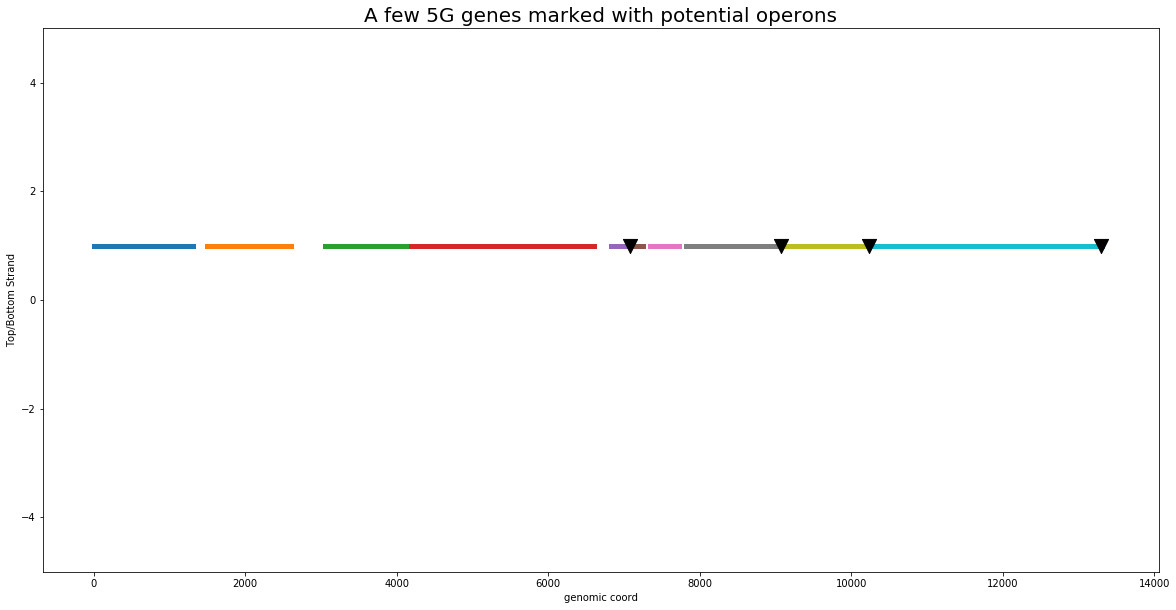

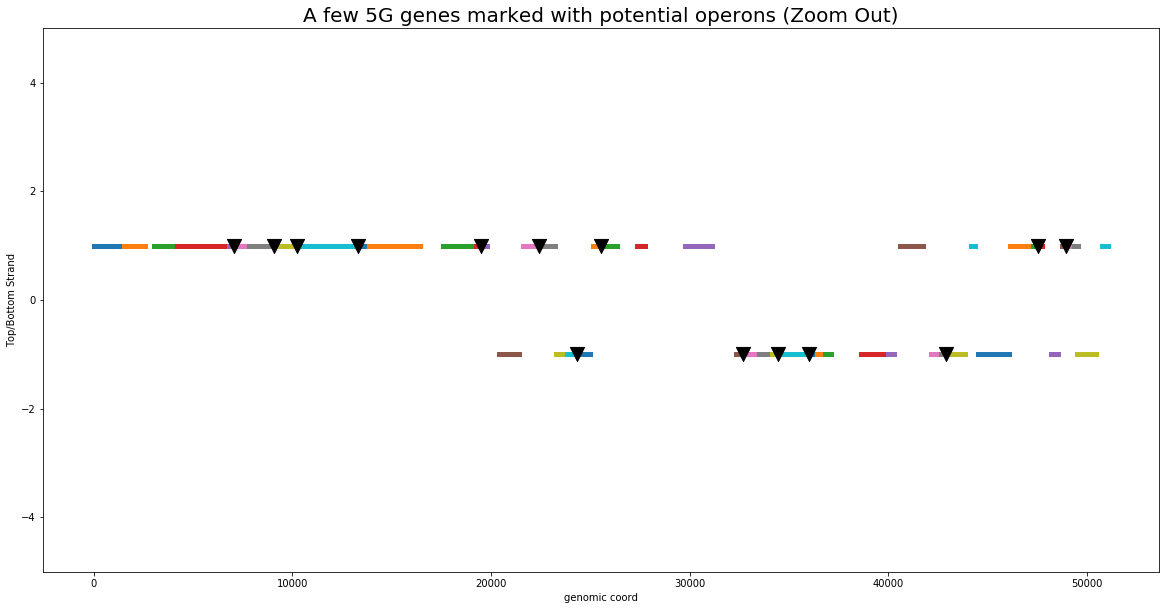

In [196]:
# plot the first few genes along the 5G genome
# Make a marker wherever there was an operon
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_5G[:10]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_5G[:4]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few 5G genes marked with potential operons", fontsize=20)
plt.show()


# Zoom out
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_5G[:50]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_5G[:14]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few 5G genes marked with potential operons (Zoom Out)", fontsize=20)
plt.show()

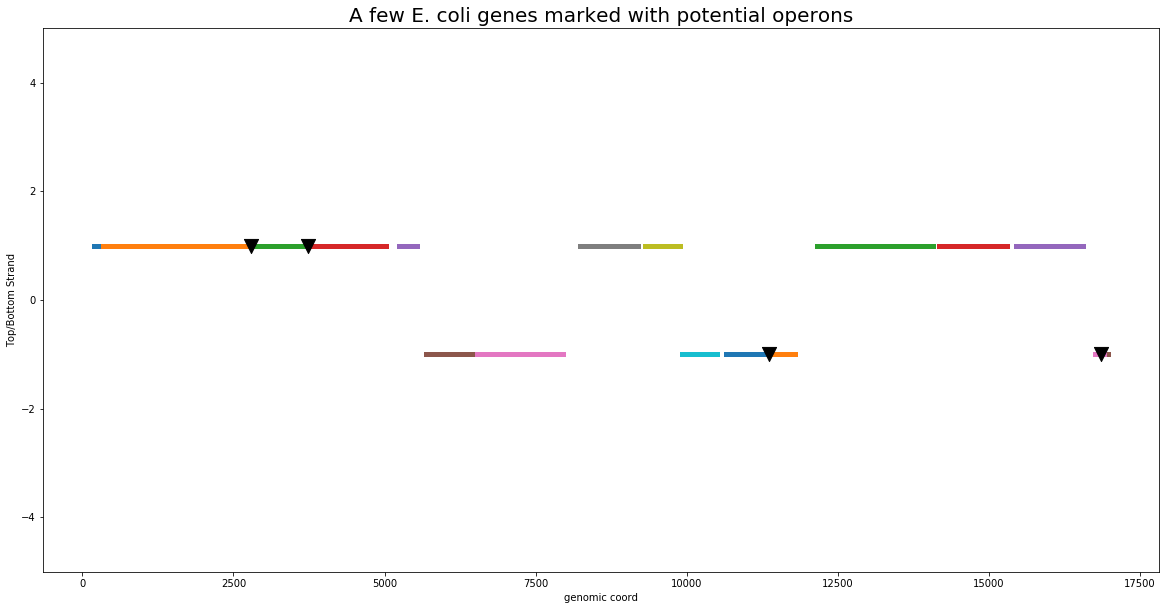

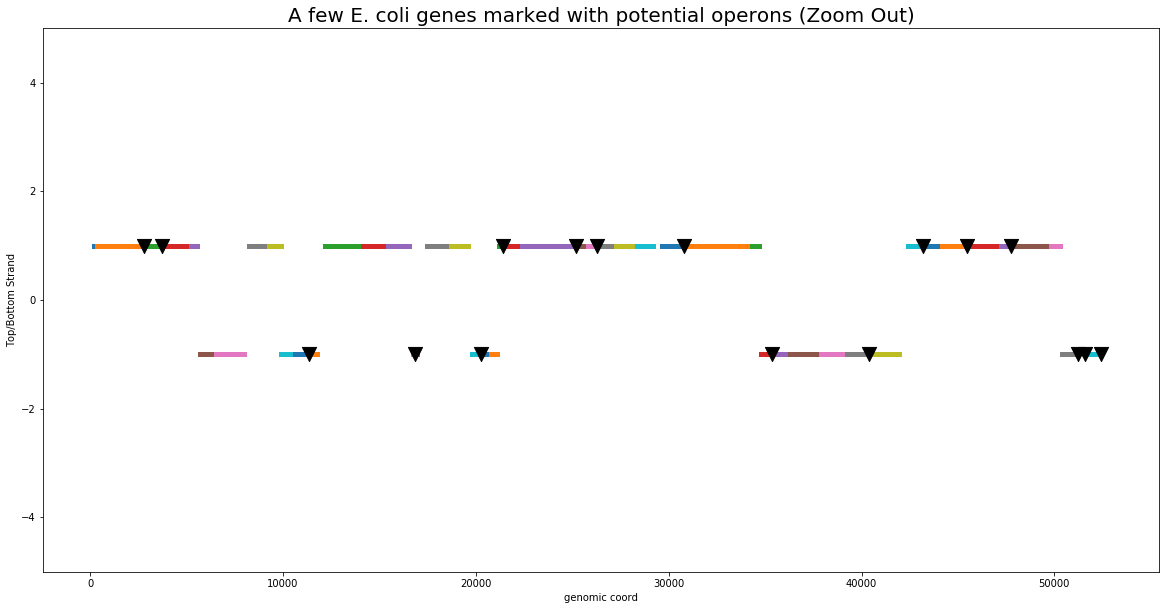

In [197]:
# plot the first few genes along the 5G genome
# Make a marker wherever there was an operon
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_ecoli[:17]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_ecoli[:4]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few E. coli genes marked with potential operons", fontsize=20)
plt.show()


# Zoom out
plt.figure(figsize=(20,10))

for x,y in cds_strand_temp_ecoli[:50]:
    plt.plot(x, y, linewidth=5, zorder=0)

for x,y in operon_locs_ecoli[:17]:
    plt.scatter(x,y, color="black",marker="v", s=200, zorder=2)

plt.ylim(-5,5)
plt.xlabel("genomic coord")
plt.ylabel("Top/Bottom Strand")
plt.title("A few E. coli genes marked with potential operons (Zoom Out)", fontsize=20)
plt.show()

### Make some truly random "promoter sets"
Take random 300 bp sections from the genome and scramble them

In [198]:
def generate_randomized_seqs(seq_record, name, k, promoter_window=300):
    '''
    Given a SeqRecord from genbank, generate k random sequences by extracting
    windows of size promoter_window then shuffling the sequence. The shuffling should 
    prevent us accidentally slicing out a actual promoter region but the fact that its
    not generated purely by an RNG means that the general frequency of bases should be
    preserved. 
    '''
    rand_seqs = []
    genome_length = len(seq_record.seq)
    
    # for as many promoters as we want to generate:
    for i in range(k):
        seq_name = "%s_RANDOM_%i" % (name, i)
        # pick a random location in the genome (not too close to the end)
        rand_loc = random.randint(0,genome_length-promoter_window)

        # get the sequence in that location
        seq = str(seq_record.seq[rand_loc:rand_loc+promoter_window])
        
        # shuffle the sequence
        rand_seq = ''.join(random.sample(seq,len(seq)))
        rand_seqs.append((seq_name,rand_seq))
        
    return rand_seqs

In [199]:
rand_proms_5G = generate_randomized_seqs(gb_5G,"5G", 4000)
rand_proms_ecoli = generate_randomized_seqs(gb_ecoli,"ECOLI", 4000)

In [200]:
rand_proms_5G[:5]
rand_proms_ecoli[:5]

[('ECOLI_RANDOM_0',
  'CAATAACCATCTGAATAGTTTGATAAGGGCAGCCGCATGTAAAATCGTTATGTTTTGTACCTCCCGATCCGCGCCCCTCATAGTGTAGCGCACTAGAGCCTTCTTGGGGGTGTGTACAGTATTATCAAAATCGCATTAGTCATGCAAATGGGGTTCATCCCGCCATGTTCTATAAACGGTACTGTTTAATCACATAACGTGCAAGTTCAAGCCTTTCCTACGCGACTCCTAAACGTCTCCAATCGACCCCCTGTAATTCTACGAATCAAGCAGTTCGACCCTTAACCTACGTTCTACATG'),
 ('ECOLI_RANDOM_1',
  'GGACTCAGCAGGCGGGCTCTAATCCCCAGGCTTGGGTCCGAAACCGAAACACTCAGAGTAGGAACCTCATACGCAGGCTGGAAATCTACAGAGATACAATCCGATATAAAAAAGGACCAATTGCATATACGAATTCGCCAACCGCTCTTGTAATGTTCAAAACTTGGTTTACCATCTAGTAATCTCATTAAAAATGACTGGTATTAAACTATCGAAAGAACTACATTTCTAGCTAACTCCCTACGTCACCATGCTAGGGGTAAAGTTGGCCGACCCTATACACACCTCGTACTCTATCTC'),
 ('ECOLI_RANDOM_2',
  'TAATAAGATTTAGCTTCACTTTCTAATCATCCCACGAAAAAGCATATGCGCATGTCATGACACTAGGAAGTTGAGCTAATGATGCGATTAGGTTTCTAAGCCTAACTTACGAAAGACAAATACTGCCTATTTACTAGTACATTGTGATTAACACCGTGACAAGAATTTCCAGACAGAAAGTATGATCTTCTAACAATGGTATAGGACAAAGGGCAGATCAAGTCTAGTAACTGTTGAGTAGGCAAACGCAAATAAATGATGGCTGAAGCAAATGCCACAATAGAAAACAACTCATTACAG'),
 ('ECOLI_RANDOM_3',

## RegulonDB predicted promoters

In [201]:
regdb_df = pd.read_csv("data/regulon_db_ecoli_promoters.tsv", sep='\t')

# filter out Sigma38 because doesn't have -35 data
regdb_df = regdb_df.loc[regdb_df['(6)Sigma']!='Sigma38']

In [202]:
print(regdb_df.columns)
regdb_df.head(10)

Index(['(1)Lend', '(2)Rend', '(3)Strand', '(4)Gene', '(5)Promoter_Name',
       '(6)Sigma', '(7)-35Box_Lend', '(8)-35Box_Rend', '(9)-35Box',
       '(10)Spacer', '(11)-10Box_Lend', '(12)-10Box_Rend', '(13)-10Box',
       '(14)Pos_1', '(15)Score', '(16)Homology_Level', '(17)P-value',
       '(18)Signicance_Level', '(19)Evidence', '(20)EvidenceType',
       '(21)Sequence'],
      dtype='object')


,(1)Lend,(2)Rend,(3)Strand,(4)Gene,(5)Promoter_Name,(6)Sigma,(7)-35Box_Lend,(8)-35Box_Rend,(9)-35Box,(10)Spacer,...,(12)-10Box_Rend,(13)-10Box,(14)Pos_1,(15)Score,(16)Homology_Level,(17)P-value,(18)Signicance_Level,(19)Evidence,(20)EvidenceType,(21)Sequence
0,5683,6459,R,yaaA,yaaAp3,Sigma24,6619.0,6625.0,tAAACTC,18,...,6600,gaTCCAT,6587,3.396,good homology,0.000036,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cagcgTAAACTCggcgtgcgcccggtgtttGATCCATtgcgttAtccgg
1,9928,10494,R,yaaH,yaaHp1,Sigma24,10622.0,10628.0,gAAAATT,18,...,10603,gaTCGTA,10590,1.896,poor homology,0.000122,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ccgggGAAAATTttcattttcccctcaaaaGATCGTAgacactGcccca
2,50380,51222,R,apaH,apaHp4,Sigma24,51324.0,51330.0,gGCACCA,19,...,51304,gaTCGAT,51293,2.970,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cgctgGGCACCAtgcagggtcactacgaaatGATCGATgaaaAtggcg
3,59687,60346,R,rluA,rluAp1,Sigma24,60479.0,60485.0,tGAACCC,16,...,60462,gaACTGA,60450,-3.530,poor homology,0.000087,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,tgcagTGAACCCgaacattcgtgacgacGAACTGAccgccAttgag
4,78848,79453,R,leuD,leuDp4,Sigma24,79621.0,79627.0,tGAACAA,15,...,79605,ggGCGAA,79594,5.216,good homology,0.000022,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTGAACAAcgaccgtctgaatccGGGCGAAcgttGtgcct
5,88028,89032,F,fruR,fruRp4,Sigma24,87833.0,87839.0,tAAAATA,13,...,87859,gaTCTCA,87864,3.045,good homology,0.000125,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTAAAATAatgcgttgagaatGATCTCAatgcGcaatt
6,118733,119284,F,ampD,ampDp5,Sigma24,118648.0,118654.0,tAAAACT,14,...,118675,aaTCATA,118681,5.285,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,catgtTAAAACTccagatagctaacgAATCATAaggtaGaaaca
7,129407,131260,R,yacH,yacHp3,Sigma24,131339.0,131345.0,tAAACTA,18,...,131320,atTCACA,131307,2.926,good homology,0.000040,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,aaattTAAACTAccgcctctttatactcggATTCACAgcacctGcgggt
8,134788,135582,R,speD,speDp1,Sigma24,135683.0,135689.0,tGAAATG,18,...,135664,aaTCCAT,135652,2.226,poor homology,0.000101,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,tggccTGAAATGccgttattacaatccggcAATCCATacggcAgcttt
9,145081,146310,F,yadE,yadEp3,Sigma24,144927.0,144933.0,cGAACTG,18,...,144958,agTCTTT,144965,2.646,good homology,0.000062,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,attgtCGAACTGggtgcgccggaggtgagtAGTCTTTggcaccAacaac


### Sanity check that RegulonDB coordinates produce the same sequence when extracted from the genbank file as the reported sequence column

In [203]:
def get_prom_reg(row):
    '''
    Sanity check. 
    If forward, left side is the -35 Box and right side is the Pos_1
    If reverse, left side is Pos_1 and right side is -35 Box. Also, reverse complement the seq
    
    Add buffer sequences on the left of 6 and right of 5
    '''
    if row['(3)Strand'] == 'F':
        l = int(row['(7)-35Box_Lend']) - 6
        r = int(row['(14)Pos_1']) + 5
        seq = ''.join(gb_ecoli.seq[l:r])
        
    elif row['(3)Strand'] == 'R':
        l = int(row['(14)Pos_1']) - 6
        r = int(row['(8)-35Box_Rend']) + 5
        seq = ''.join(gb_ecoli.seq[l:r].reverse_complement())
        
    return seq

In [204]:
regdb_df['test_prom'] = regdb_df.apply(lambda x: get_prom_reg(x), axis=1)
regdb_df.head(10)

,(1)Lend,(2)Rend,(3)Strand,(4)Gene,(5)Promoter_Name,(6)Sigma,(7)-35Box_Lend,(8)-35Box_Rend,(9)-35Box,(10)Spacer,...,(13)-10Box,(14)Pos_1,(15)Score,(16)Homology_Level,(17)P-value,(18)Signicance_Level,(19)Evidence,(20)EvidenceType,(21)Sequence,test_prom
0,5683,6459,R,yaaA,yaaAp3,Sigma24,6619.0,6625.0,tAAACTC,18,...,gaTCCAT,6587,3.396,good homology,0.000036,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cagcgTAAACTCggcgtgcgcccggtgtttGATCCATtgcgttAtccgg,CAGCGTAAACTCGGCGTGCGCCCGGTGTTTGATCCATTGCGTTATCCGG
1,9928,10494,R,yaaH,yaaHp1,Sigma24,10622.0,10628.0,gAAAATT,18,...,gaTCGTA,10590,1.896,poor homology,0.000122,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ccgggGAAAATTttcattttcccctcaaaaGATCGTAgacactGcccca,CCGGGGAAAATTTTCATTTTCCCCTCAAAAGATCGTAGACACTGCCCCA
2,50380,51222,R,apaH,apaHp4,Sigma24,51324.0,51330.0,gGCACCA,19,...,gaTCGAT,51293,2.970,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,cgctgGGCACCAtgcagggtcactacgaaatGATCGATgaaaAtggcg,CGCTGGGCACCATGCAGGGTCACTACGAAATGATCGATGAAAATGGCG
3,59687,60346,R,rluA,rluAp1,Sigma24,60479.0,60485.0,tGAACCC,16,...,gaACTGA,60450,-3.530,poor homology,0.000087,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,tgcagTGAACCCgaacattcgtgacgacGAACTGAccgccAttgag,TGCAGTGAACCCGAACATTCGTGACGACGAACTGACCGCCATTGAG
4,78848,79453,R,leuD,leuDp4,Sigma24,79621.0,79627.0,tGAACAA,15,...,ggGCGAA,79594,5.216,good homology,0.000022,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTGAACAAcgaccgtctgaatccGGGCGAAcgttGtgcct,GGCGATGAACAACGACCGTCTGAATCCGGGCGAACGTTGTGCCT
5,88028,89032,F,fruR,fruRp4,Sigma24,87833.0,87839.0,tAAAATA,13,...,gaTCTCA,87864,3.045,good homology,0.000125,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,ggcgaTAAAATAatgcgttgagaatGATCTCAatgcGcaatt,GGCGATAAAATAATGCGTTGAGAATGATCTCAATGCGCAATT
6,118733,119284,F,ampD,ampDp5,Sigma24,118648.0,118654.0,tAAAACT,14,...,aaTCATA,118681,5.285,good homology,0.000097,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,catgtTAAAACTccagatagctaacgAATCATAaggtaGaaaca,CATGTTAAAACTCCAGATAGCTAACGAATCATAAGGTAGAAACA
7,129407,131260,R,yacH,yacHp3,Sigma24,131339.0,131345.0,tAAACTA,18,...,atTCACA,131307,2.926,good homology,0.000040,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,aaattTAAACTAccgcctctttatactcggATTCACAgcacctGcgggt,AAATTTAAACTACCGCCTCTTTATACTCGGATTCACAGCACCTGCGGGT
8,134788,135582,R,speD,speDp1,Sigma24,135683.0,135689.0,tGAAATG,18,...,aaTCCAT,135652,2.226,poor homology,0.000101,p < 0.001,Sigma Factor inferred computationally without ...,weak evidence,tggccTGAAATGccgttattacaatccggcAATCCATacggcAgcttt,TGGCCTGAAATGCCGTTATTACAATCCGGCAATCCATACGGCAGCTTT
9,145081,146310,F,yadE,yadEp3,Sigma24,144927.0,144933.0,cGAACTG,18,...,agTCTTT,144965,2.646,good homology,0.000062,p < 0.0001,Sigma Factor inferred computationally without ...,weak evidence,attgtCGAACTGggtgcgccggaggtgagtAGTCTTTggcaccAacaac,ATTGTCGAACTGGGTGCGCCGGAGGTGAGTAGTCTTTGGCACCAACAAC


In [205]:
sum(regdb_df['test_prom'] != regdb_df['(21)Sequence'].apply(lambda x: x.upper()))
# ^^ Indeed the test_prom and (21)Sequence columns match! (All False sums to 0)

0

### Extract regulonDB sequences into a promoter set

In [206]:
regdb_p_set = [('|%s|%s'%(y,z),x.upper()) for x,y,z in regdb_df[['(21)Sequence','(4)Gene','(6)Sigma']].values]

In [207]:
print(len(regdb_p_set))
regdb_p_set[:5]

5444


[('|yaaA|Sigma24', 'CAGCGTAAACTCGGCGTGCGCCCGGTGTTTGATCCATTGCGTTATCCGG'),
 ('|yaaH|Sigma24', 'CCGGGGAAAATTTTCATTTTCCCCTCAAAAGATCGTAGACACTGCCCCA'),
 ('|apaH|Sigma24', 'CGCTGGGCACCATGCAGGGTCACTACGAAATGATCGATGAAAATGGCG'),
 ('|rluA|Sigma24', 'TGCAGTGAACCCGAACATTCGTGACGACGAACTGACCGCCATTGAG'),
 ('|leuD|Sigma24', 'GGCGATGAACAACGACCGTCTGAATCCGGGCGAACGTTGTGCCT')]

In [209]:
print(rand_proms_ecoli[:5])
print()
print(naive_p_set_ecoli[:5])
print()
print(operon_p_set_ecoli[:5])
print()
print(regdb_p_set[:5])

[('ECOLI_RANDOM_0', 'CAATAACCATCTGAATAGTTTGATAAGGGCAGCCGCATGTAAAATCGTTATGTTTTGTACCTCCCGATCCGCGCCCCTCATAGTGTAGCGCACTAGAGCCTTCTTGGGGGTGTGTACAGTATTATCAAAATCGCATTAGTCATGCAAATGGGGTTCATCCCGCCATGTTCTATAAACGGTACTGTTTAATCACATAACGTGCAAGTTCAAGCCTTTCCTACGCGACTCCTAAACGTCTCCAATCGACCCCCTGTAATTCTACGAATCAAGCAGTTCGACCCTTAACCTACGTTCTACATG'), ('ECOLI_RANDOM_1', 'GGACTCAGCAGGCGGGCTCTAATCCCCAGGCTTGGGTCCGAAACCGAAACACTCAGAGTAGGAACCTCATACGCAGGCTGGAAATCTACAGAGATACAATCCGATATAAAAAAGGACCAATTGCATATACGAATTCGCCAACCGCTCTTGTAATGTTCAAAACTTGGTTTACCATCTAGTAATCTCATTAAAAATGACTGGTATTAAACTATCGAAAGAACTACATTTCTAGCTAACTCCCTACGTCACCATGCTAGGGGTAAAGTTGGCCGACCCTATACACACCTCGTACTCTATCTC'), ('ECOLI_RANDOM_2', 'TAATAAGATTTAGCTTCACTTTCTAATCATCCCACGAAAAAGCATATGCGCATGTCATGACACTAGGAAGTTGAGCTAATGATGCGATTAGGTTTCTAAGCCTAACTTACGAAAGACAAATACTGCCTATTTACTAGTACATTGTGATTAACACCGTGACAAGAATTTCCAGACAGAAAGTATGATCTTCTAACAATGGTATAGGACAAAGGGCAGATCAAGTCTAGTAACTGTTGAGTAGGCAAACGCAAATAAATGATGGCTGAAGCAAATGCCACAATAGAAAACAACTCATTACAG'), ('ECOLI_RANDOM_3', 'TGTCTTG

# Turn a corpus of promoters into "words" and calculate frequency look up tables

In [332]:
# n-mer n-grams
    # 1mer bigrams
    # 1mer trigrams
    # 3mer bigrams
    # 3mer trigrams
    # 5mer bigrams
    # 5mer trigrams... etc
    
word_strategies = [
    '1mer-trigrams',    # p(A | G, G)
    '3mer-bigrams',     # p(AAT | GGC)
    '5mer1mer-bigrams', # p(A | ATTAA)
]

def make_kmer_ngrams(corpus,k,n):
    '''
    Given a corpus of promoters, break sequence in mers of size k
    and use n-gram modeling
    '''
    
    def list2key(l):
        '''Given a list, convert it to a tuple so it can be a dict key'''
        if len(l) == 0:
            return None
        elif len(l) == 1:
            return l[0]
        else:
            return tuple(l)
    
    numer_gram_lookup = {}
    denom_gram_lookup = {}
    freq_gram_lookup = {}

    all_grams = [] # collect all possible n grams of mer size k
    
    # for every promoter sequence
    for _,prom_seq in corpus:    
        # loop through the end of the sequence (minus the distance of the last full gram)
        stop_coord = -((k*n)-1)
        if stop_coord == 0:
            stop_coord = -1
        for i,nuc in enumerate(prom_seq[:stop_coord]):
            grams = [] # collect the n-gram (aka bi or trigram)
            for step in range(n):
                # i is the current loc in the seq
                # k is the size of the mer to get
                # k*step is the offset within the n-gram (aka first 3-mer vs second 3-mer in a bigram)
                gram = prom_seq[i+(k*step):i+k+(k*step)]
                grams.append(gram)
            
            all_grams.append(grams)
            
    # now that we've collected all the k-mer n-grams, let's count the number of (n-1)-grams
    # and collect them in the denomenator lookup
    for ngram in all_grams:
        # ************************
        # add the numerator counts
        # ************************
        # convert the full ngram to a tuple or unigram so it can be a dictionary key
        ngram = list2key(ngram)
        
        # Add the ngram if it's not already in the lookup table
        if ngram not in numer_gram_lookup:
            numer_gram_lookup[ngram] = 0

        # increment the count
        numer_gram_lookup[ngram] += 1

        
        # if not a unigram model, get the denominator counts too
        if n > 1:
            # **************************
            # add the denominator counts
            # **************************
            denom_gram = ngram[:n-1] # if its a trigram of [AAA, TTT, GGG], this gets [AAA,TTT]

            # convert to tuple or unigram so it can be a dictionary key
            denom_gram = list2key(denom_gram)

            # Add the n-1 gram if it's not already in the lookup table
            if denom_gram not in denom_gram_lookup:
                denom_gram_lookup[denom_gram] = 0

            # increment the count
            denom_gram_lookup[denom_gram] += 1

        
        
    # now that we've counted all the numerator and denominator values, 
    # calculate the conditional probabilities
    for ngram in all_grams:
        denom_gram = ngram[:n-1] # if its a trigram of [AAA, TTT, GGG], this gets [AAA,TTT]
        
        ngram = list2key(ngram)
        denom_gram = list2key(denom_gram)
        
        numer = numer_gram_lookup[ngram]
        denom = len(all_grams) if not denom_gram else denom_gram_lookup[denom_gram]
        freq_gram_lookup[ngram] = numer/denom
        
        
            
    return all_grams, numer_gram_lookup, denom_gram_lookup, freq_gram_lookup


a,n,d,f = make_kmer_ngrams([('dummy',"AAAAAATTTGGGCCC")], 3, 3)
a

[['AAA', 'AAA', 'TTT'],
 ['AAA', 'AAT', 'TTG'],
 ['AAA', 'ATT', 'TGG'],
 ['AAA', 'TTT', 'GGG'],
 ['AAT', 'TTG', 'GGC'],
 ['ATT', 'TGG', 'GCC'],
 ['TTT', 'GGG', 'CCC']]

In [302]:
sum([f[x] for x in f])
f

{('AAA', 'AAA'): 0.25,
 ('AAA', 'AAT'): 0.25,
 ('AAA', 'ATT'): 0.25,
 ('AAA', 'TTT'): 0.25,
 ('AAT', 'TTG'): 1.0,
 ('ATT', 'TGG'): 1.0,
 ('TTT', 'GGG'): 1.0,
 ('TTG', 'GGC'): 1.0,
 ('TGG', 'GCC'): 1.0,
 ('GGG', 'CCC'): 1.0}

# check mer count distributions across model params

In [347]:
def quick_hist(data, k, n, set_name):
    plt.figure(figsize=(20,10))
    plt.hist(data)
    #plt.yscale('log')
    plt.xlabel("%i-mer %i-gram counts" % (k,n))
    plt.ylabel("Number of %i-mer %i-grams with that count" % (k,n))
    plt.title("Distribution of %i-mer %i-grams in %s promoter set" %(k,n,set_name))
#    plt.legend(fontsize = 20)
    plt.show()


def hist_grid(model_combos,p_set_results, num_rows, num_cols):
    # Create a small multiples plot of distribution across model grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True, figsize=(20,20))
    axes_list = [item for sublist in axes for item in sublist] 

    for k,n in model_combos:
        ax = axes_list.pop(0)
        for p_set in p_set_results: # dictionary of p-sets with all model combos
            res = p_set_results[p_set]
            # get the numerator counts
            data = [res[(k,n)]['num'][x] for x in res[(k,n)]['num']]
            
            # plot in ax
            ax.hist(data,label=p_set)
            
        ax.set_title("Distribution of %i-mer %i-grams" % (k,n), fontsize=14)
        ax.set_xlabel("%i-mer %i-gram counts" % (k,n))
        ax.set_ylabel("Number of %i-mer %i-grams with that count" % (k,n))
        #ax.set_yscale('log')
        #ax.set_xlim(0,220000) # <largest is ~214,000
        #ax.set_ylim(0.1,1000)
        #plt.show()

    for ax in axes_list:
        ax.remove()

    plt.tight_layout()

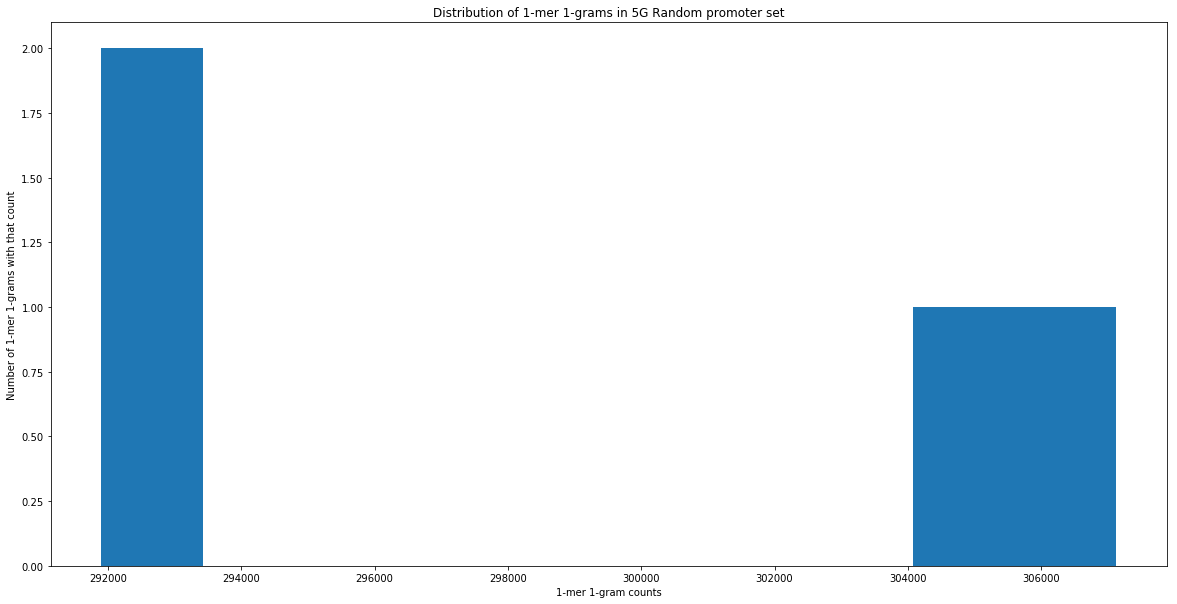

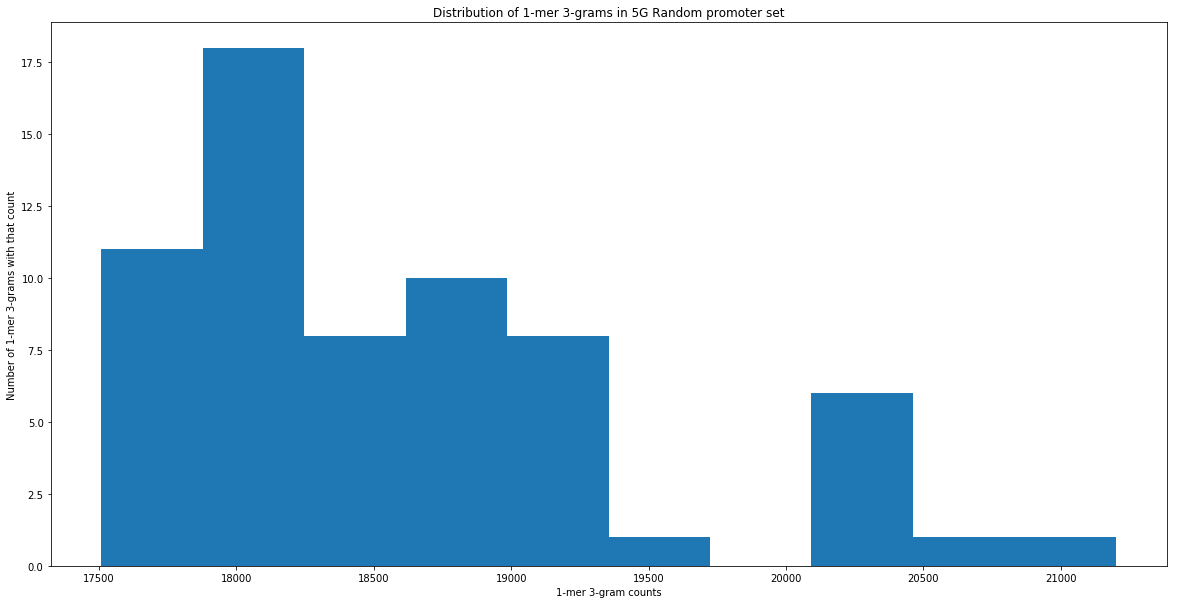

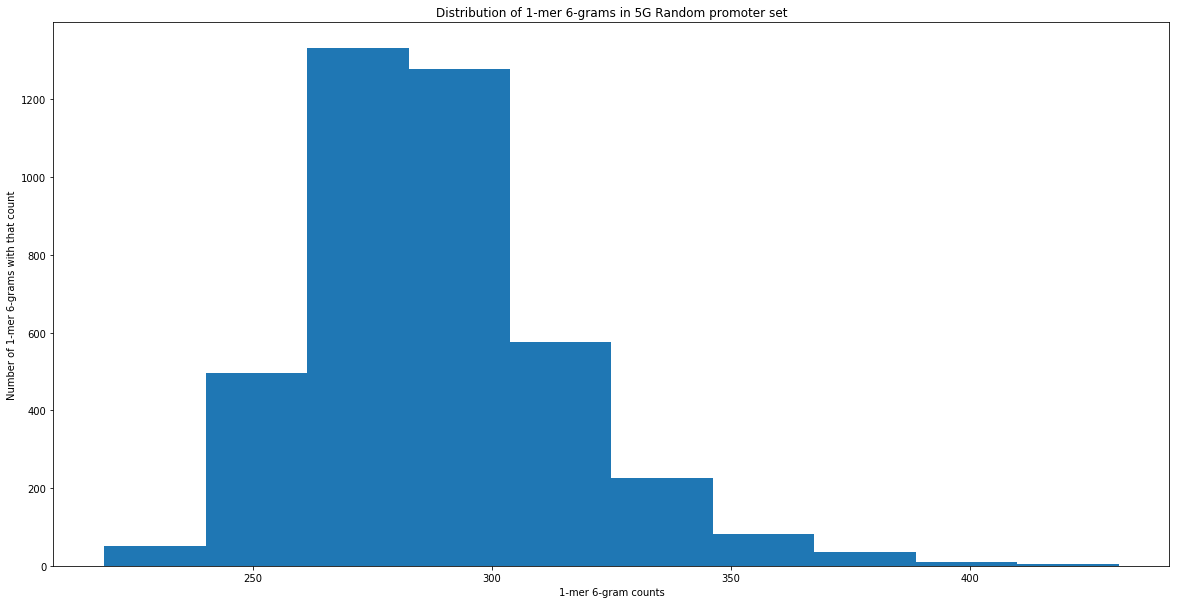

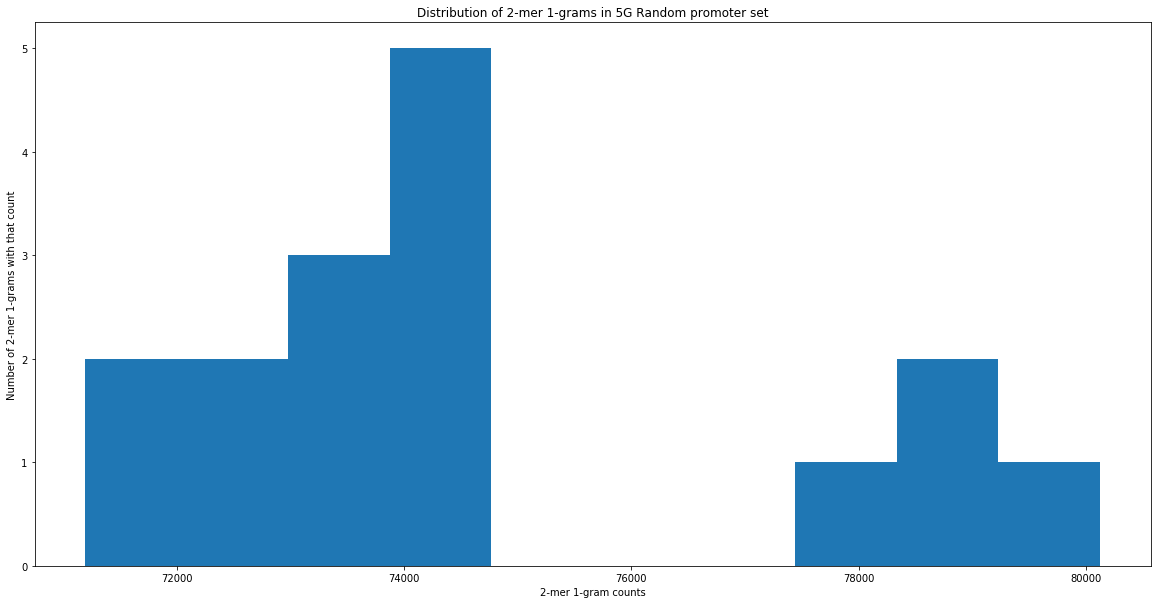

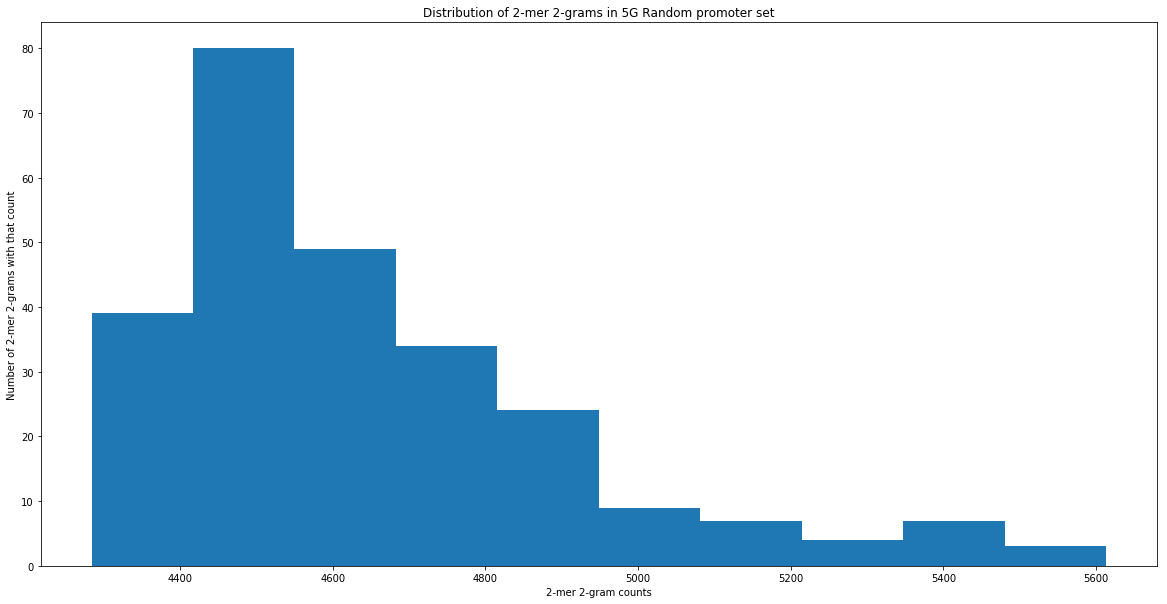

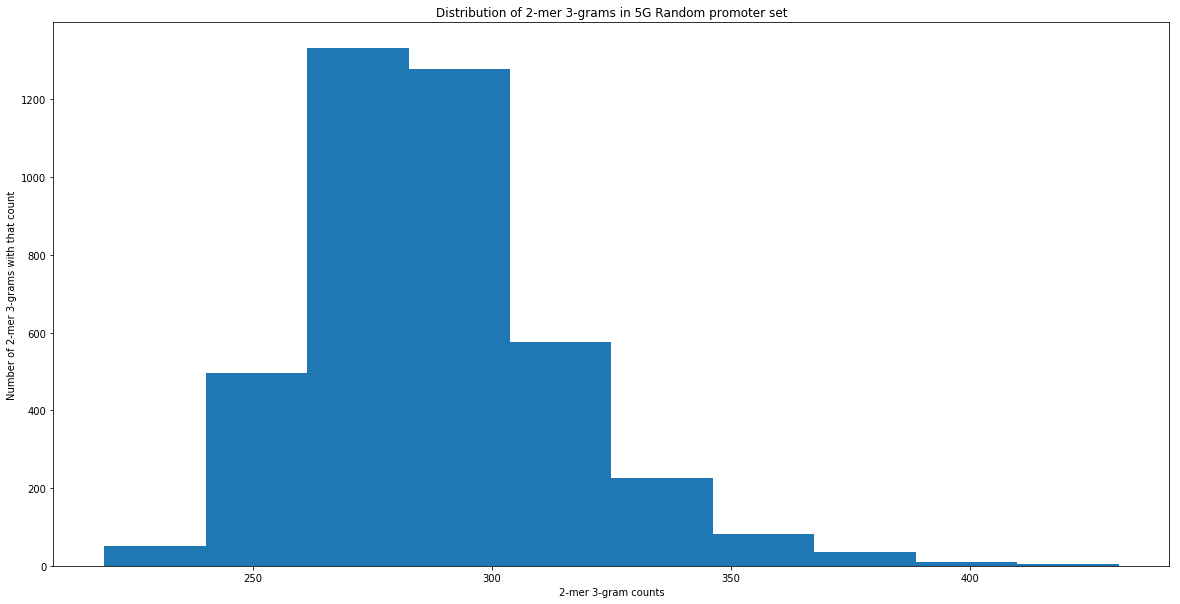

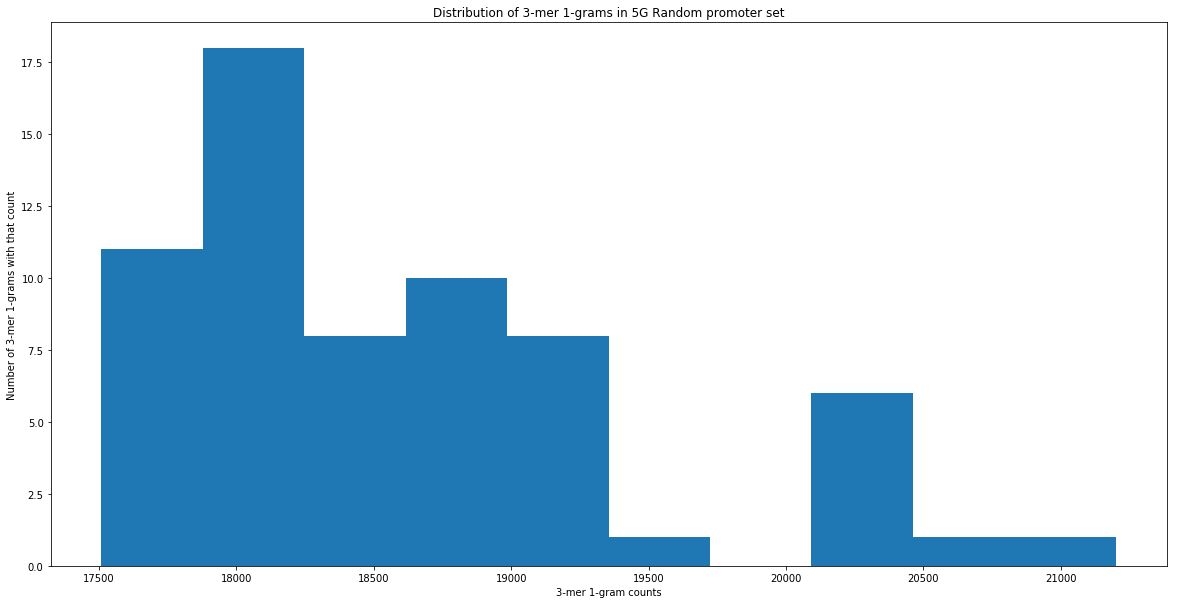

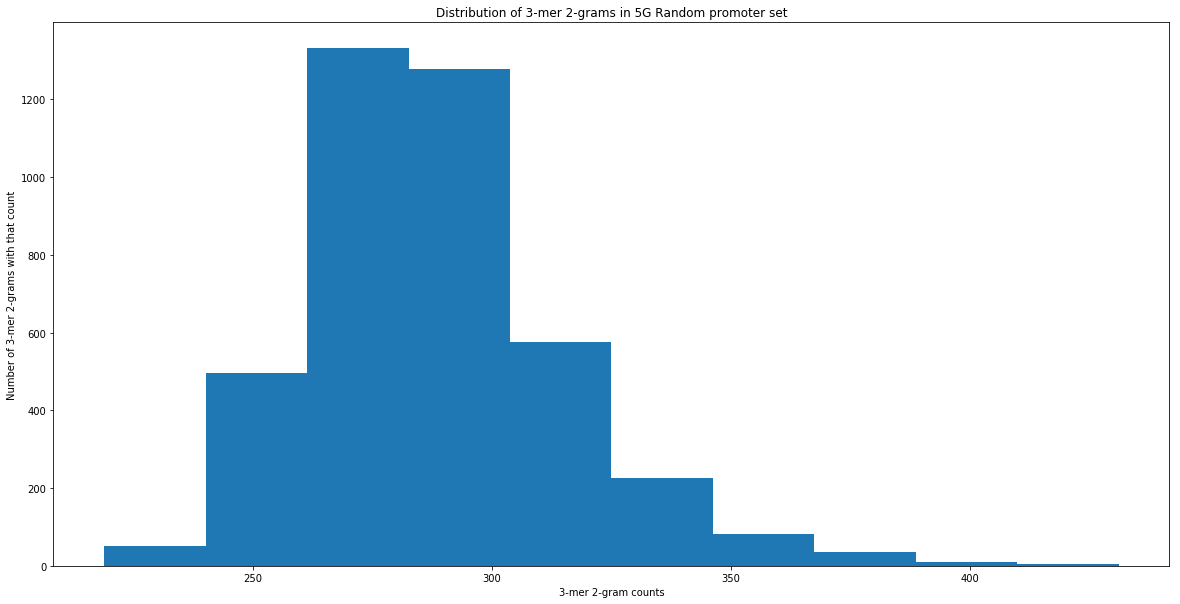

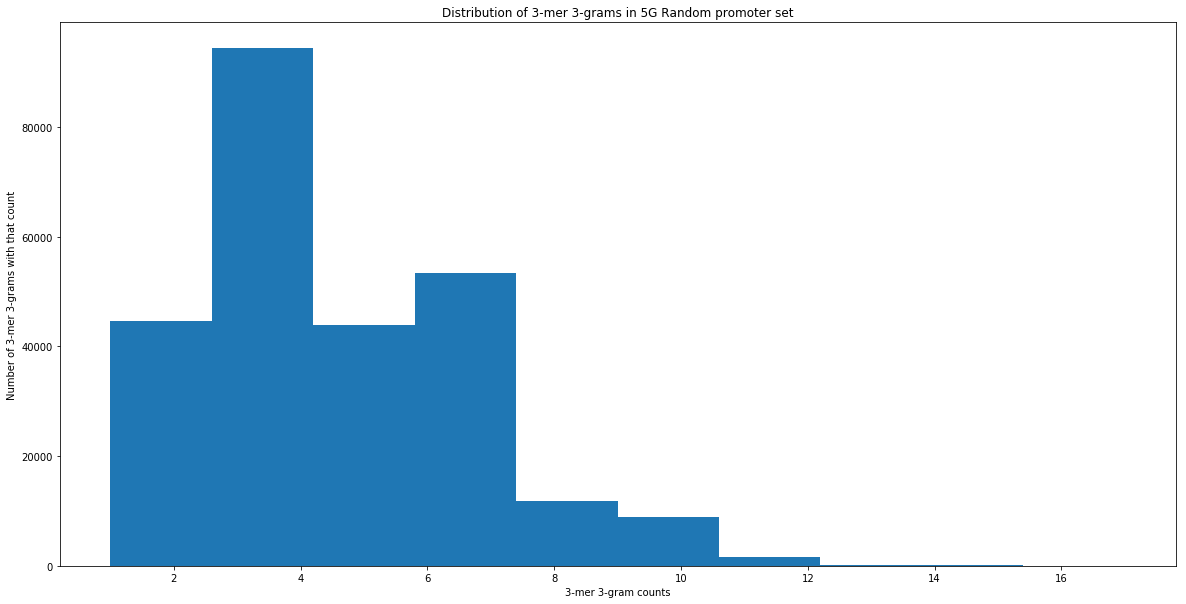

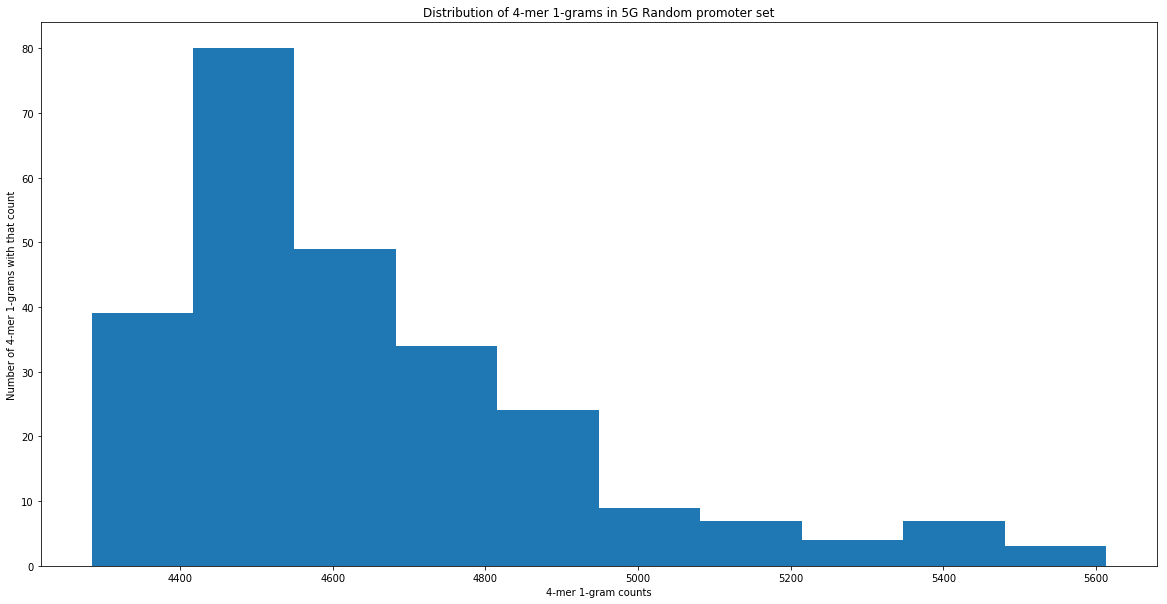

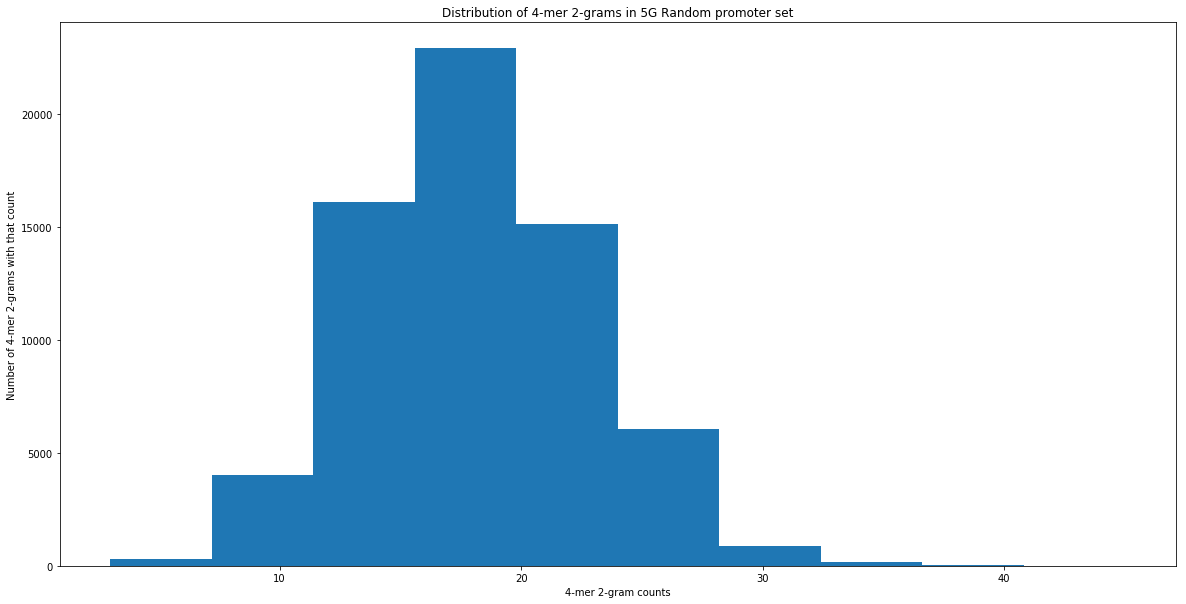

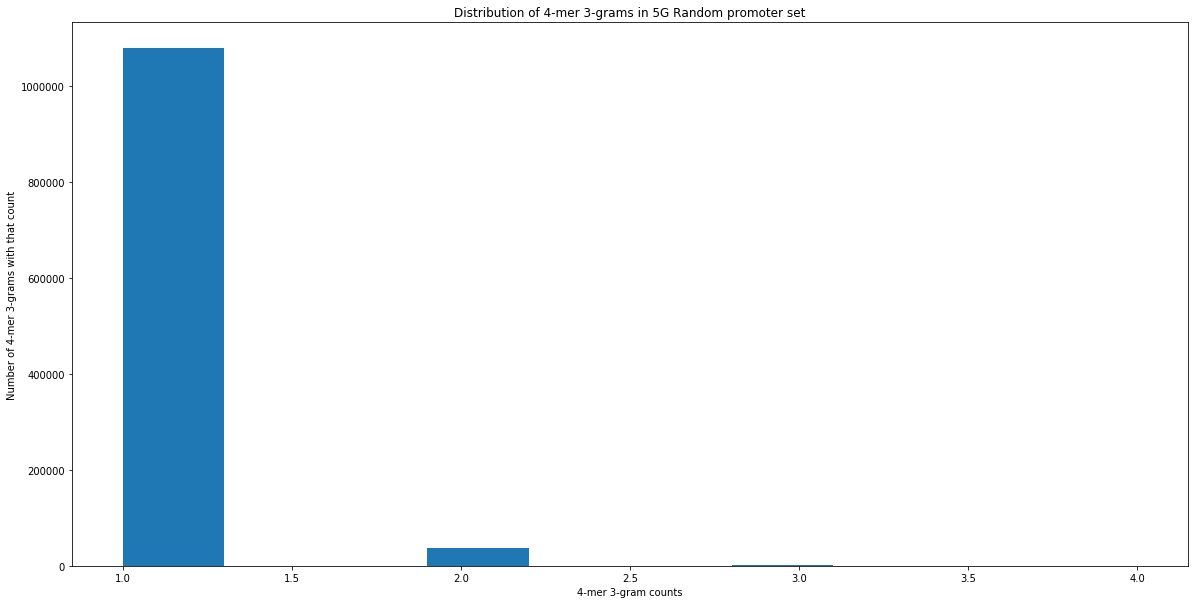

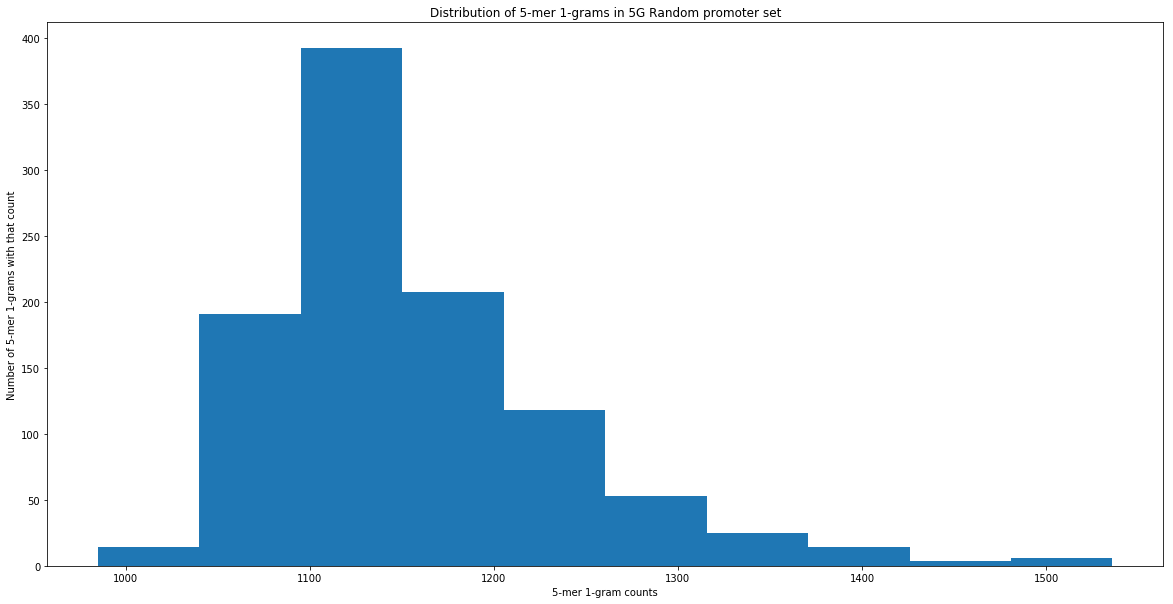

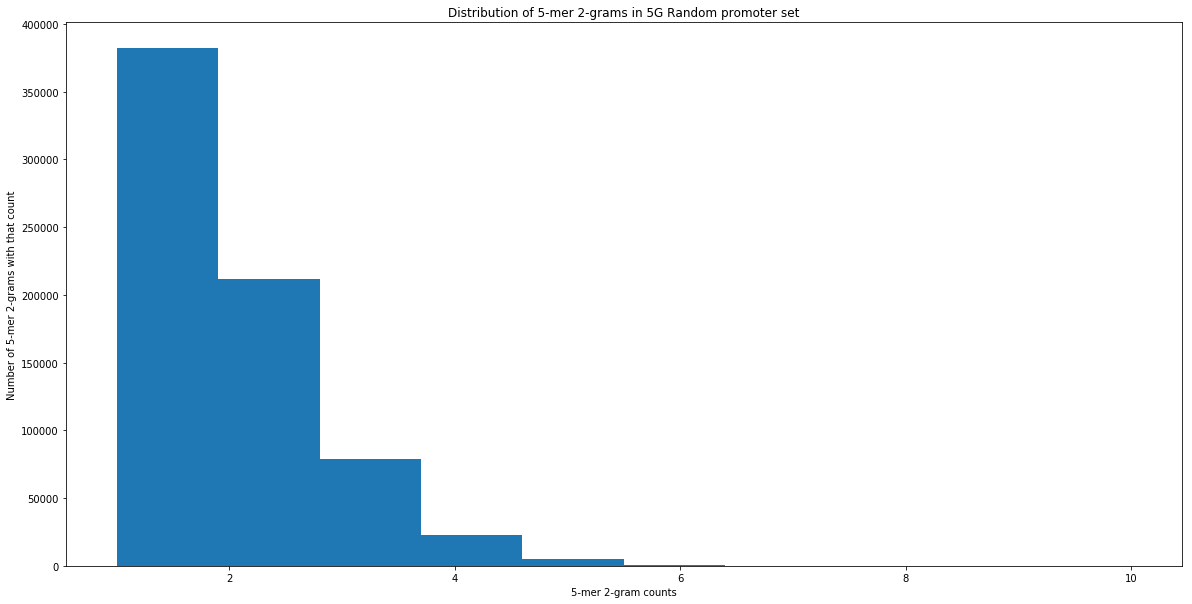

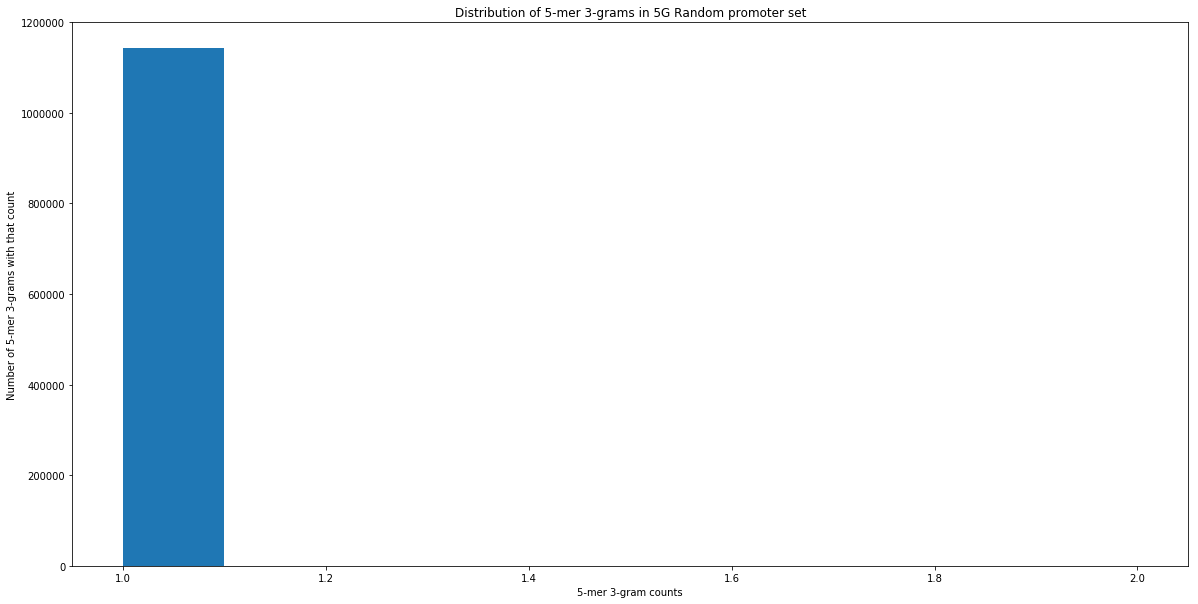

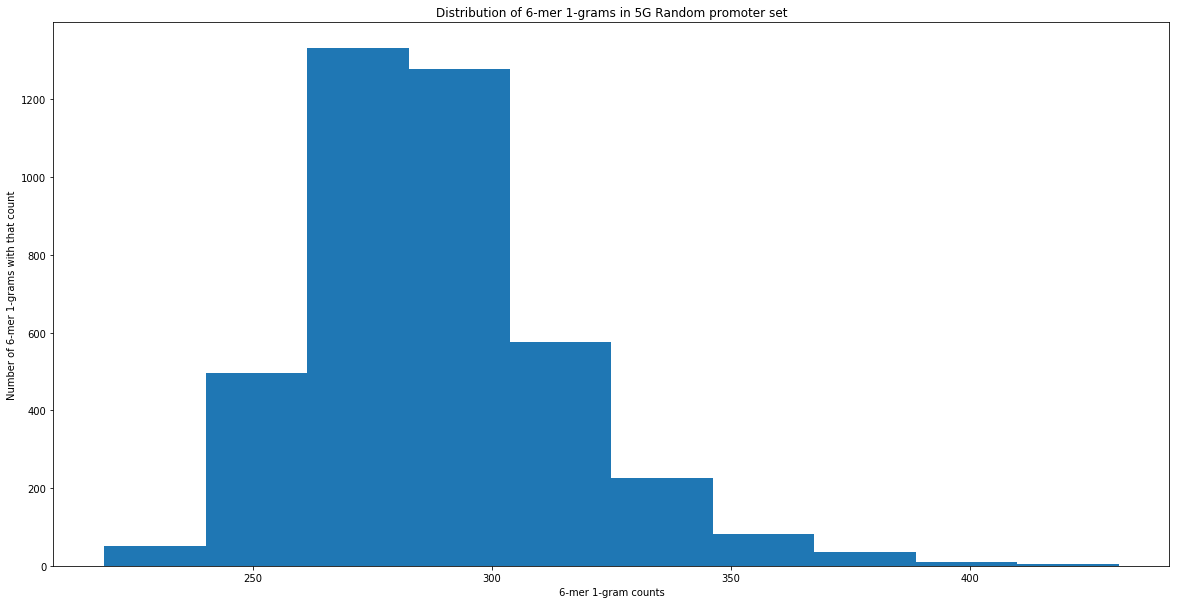

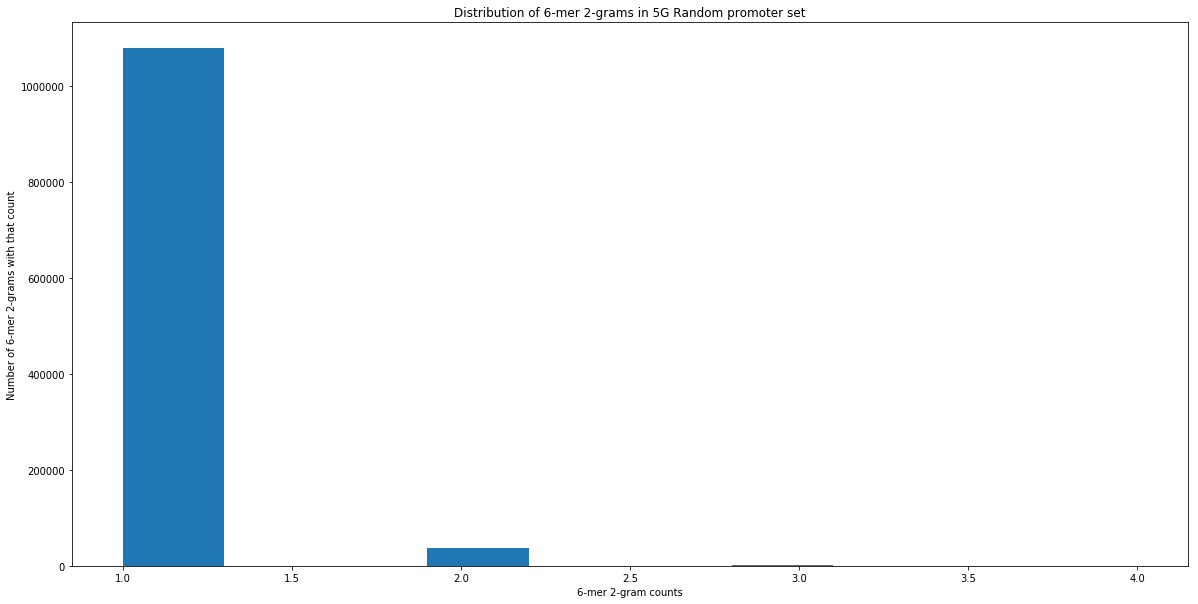

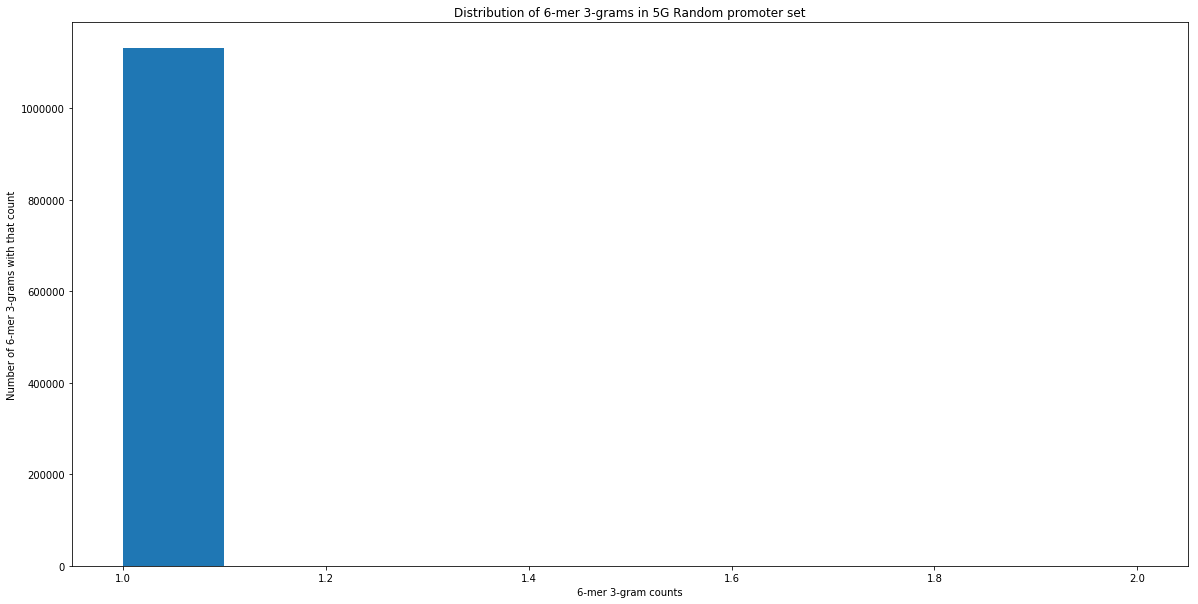

In [342]:
def model_grid(promoter_set, p_set_name, model_combos):
    kn_model_results = {}

    for (k, n) in model_combos:
        print("Running %i-mer %i-grams for %s" %(k,n,p_set_name))
        _,num_dict,denom_dict,freq_dict = make_kmer_ngrams(rand_proms_5G, k, n)

        res = {}
        res['num'] = num_dict
        res['denom'] = denom_dict
        res['freq'] = freq_dict

        kn_model_results[(k,n)] = res

#         num_counts = [num_dict[x] for x in num_dict]

#         quick_hist(num_counts, k,n,"5G Random")

    return kn_model_results
    

In [343]:
# list of (k,n) model combos to try
model_combos = [
    (1,1),(1,3),(1,6), 
    (2,1),(2,2),(2,3),
    (3,1),(3,2),(3,3),
    (4,1),(4,2),(4,3),
    (5,1),(5,2),(5,3),
    (6,1),(6,2),(6,3)
]

p_sets_to_try = [
    (rand_proms_ecoli, "Ecoli Random"),
    (naive_p_set_ecoli, "Ecoli Naive"),
    (operon_p_set_ecoli, "Ecoli Operon"),
]

all_results = {}
for (corpus, name) in p_sets_to_try:
    p_set_res = model_grid(corpus, name, model_combos)
    
    all_results[name] = p_set_res
    
    

Running 1-mer 1-grams for Ecoli Random
Running 1-mer 3-grams for Ecoli Random
Running 1-mer 6-grams for Ecoli Random
Running 2-mer 1-grams for Ecoli Random
Running 2-mer 2-grams for Ecoli Random
Running 2-mer 3-grams for Ecoli Random
Running 3-mer 1-grams for Ecoli Random
Running 3-mer 2-grams for Ecoli Random
Running 3-mer 3-grams for Ecoli Random
Running 4-mer 1-grams for Ecoli Random
Running 4-mer 2-grams for Ecoli Random
Running 4-mer 3-grams for Ecoli Random
Running 5-mer 1-grams for Ecoli Random
Running 5-mer 2-grams for Ecoli Random
Running 5-mer 3-grams for Ecoli Random
Running 6-mer 1-grams for Ecoli Random
Running 6-mer 2-grams for Ecoli Random
Running 6-mer 3-grams for Ecoli Random
Running 1-mer 1-grams for Ecoli Naive
Running 1-mer 3-grams for Ecoli Naive
Running 1-mer 6-grams for Ecoli Naive
Running 2-mer 1-grams for Ecoli Naive
Running 2-mer 2-grams for Ecoli Naive
Running 2-mer 3-grams for Ecoli Naive
Running 3-mer 1-grams for Ecoli Naive
Running 3-mer 2-grams for Ecoli 

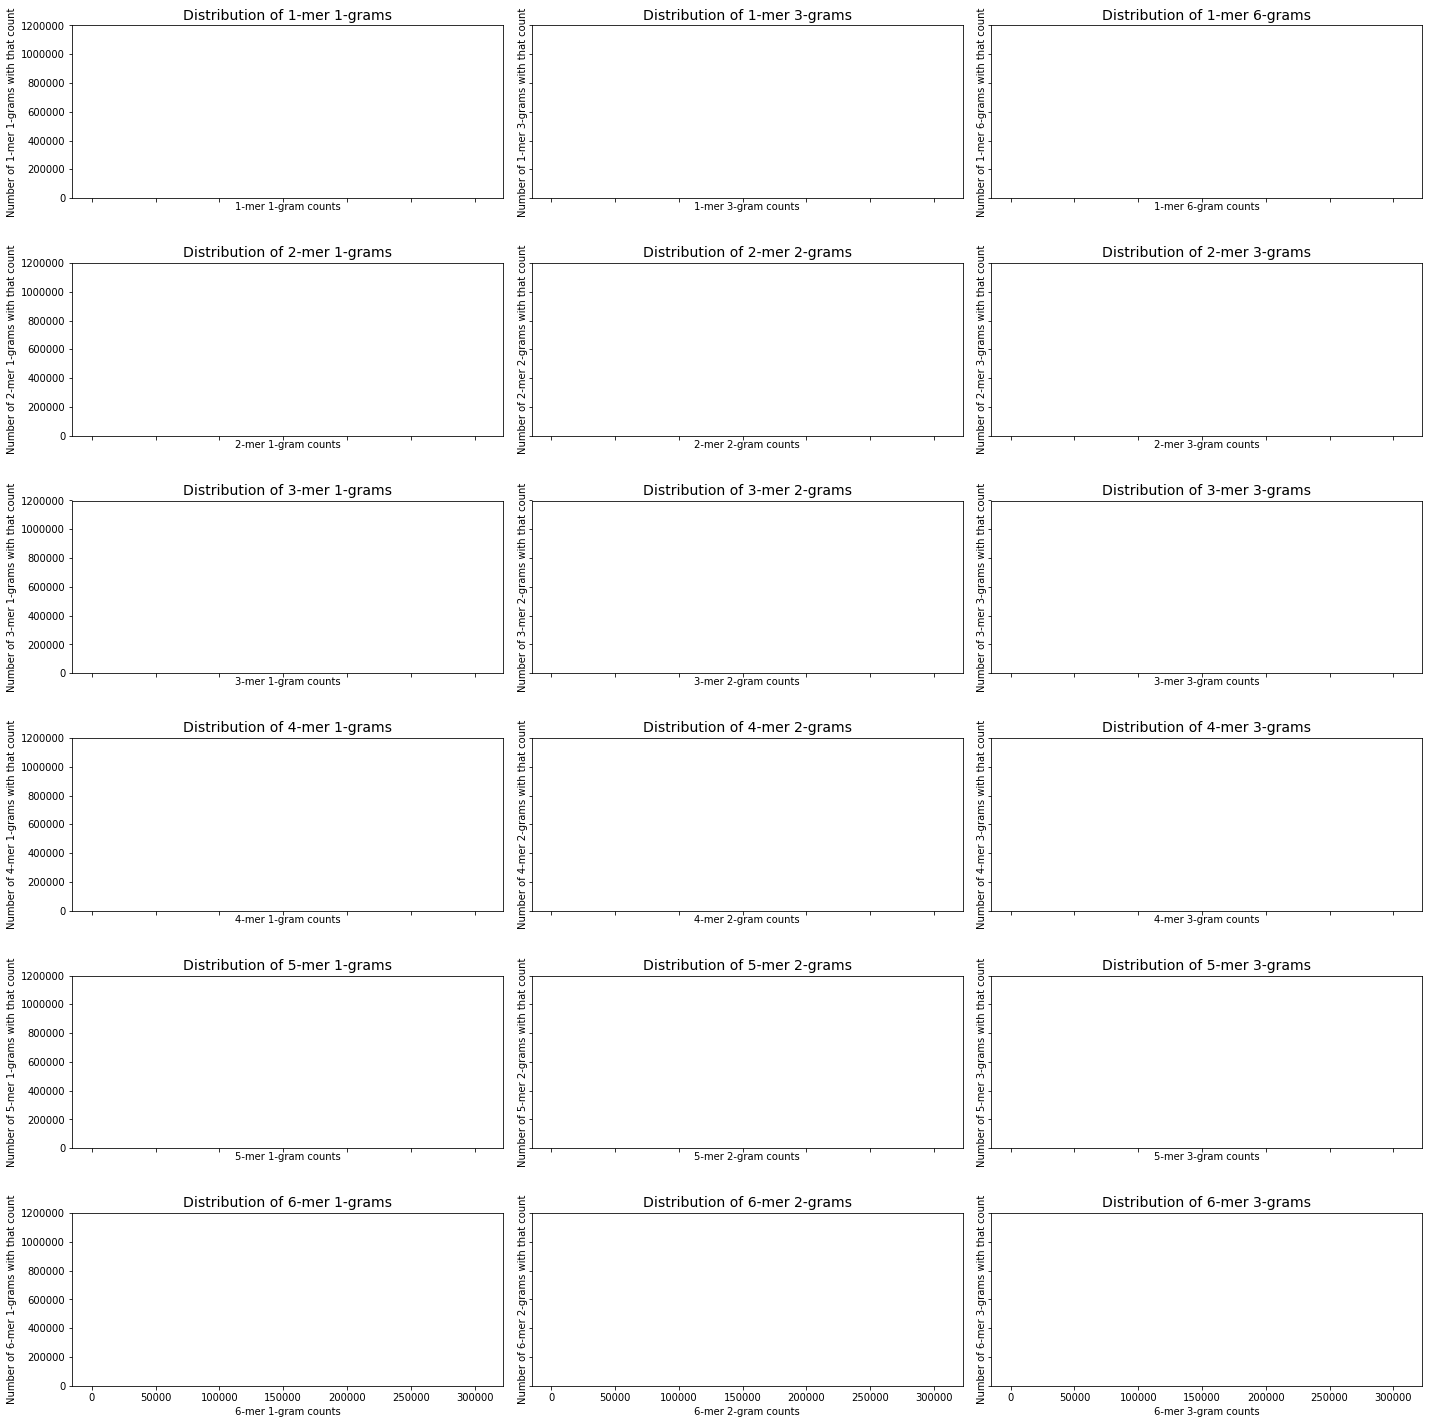

In [348]:
hist_grid(model_combos,all_results, 6, 3)

In [303]:
a,n,d,f = make_kmer_ngrams(rand_proms_5G, 4, 2)

In [306]:
n

{('GGTG', 'GCAG'): 22,
 ('GTGG', 'CAGA'): 18,
 ('TGGC', 'AGAA'): 16,
 ('GGCA', 'GAAG'): 19,
 ('GCAG', 'AAGG'): 22,
 ('CAGA', 'AGGC'): 16,
 ('AGAA', 'GGCA'): 19,
 ('GAAG', 'GCAG'): 28,
 ('AAGG', 'CAGG'): 26,
 ('AGGC', 'AGGC'): 13,
 ('GGCA', 'GGCC'): 13,
 ('GCAG', 'GCCA'): 10,
 ('CAGG', 'CCAG'): 14,
 ('AGGC', 'CAGC'): 16,
 ('GGCC', 'AGCC'): 13,
 ('GCCA', 'GCCA'): 31,
 ('CCAG', 'CCAA'): 26,
 ('CAGC', 'CAAG'): 24,
 ('AGCC', 'AAGA'): 21,
 ('GCCA', 'AGAG'): 15,
 ('CCAA', 'GAGC'): 15,
 ('CAAG', 'AGCA'): 17,
 ('AAGA', 'GCAA'): 29,
 ('AGAG', 'CAAC'): 17,
 ('GAGC', 'AACG'): 21,
 ('AGCA', 'ACGC'): 16,
 ('GCAA', 'CGCC'): 19,
 ('CAAC', 'GCCT'): 21,
 ('AACG', 'CCTG'): 19,
 ('ACGC', 'CTGT'): 18,
 ('CGCC', 'TGTC'): 15,
 ('GCCT', 'GTCA'): 22,
 ('CCTG', 'TCAG'): 16,
 ('CTGT', 'CAGA'): 24,
 ('TGTC', 'AGAA'): 21,
 ('GTCA', 'GAAT'): 19,
 ('TCAG', 'AATG'): 19,
 ('CAGA', 'ATGG'): 19,
 ('AGAA', 'TGGC'): 17,
 ('GAAT', 'GGCC'): 21,
 ('AATG', 'GCCG'): 13,
 ('ATGG', 'CCGA'): 15,
 ('TGGC', 'CGAA'): 16,
 ('GGCC', '

In [311]:
a_n,n_n,d_n,f_n = make_kmer_ngrams(operon_p_set_5G, 4, 2)

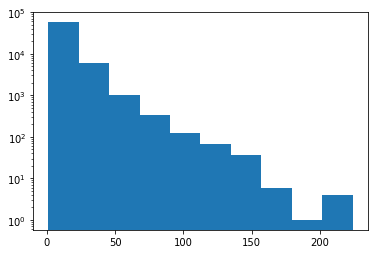

In [318]:
h = [n_n[x] for x in n_n]
plt.hist(h)
plt.yscale('log')
plt.show()

In [257]:
a = {['x','y']: 1}

TypeError: unhashable type: 'list'

In [254]:
a['x'] += 1

In [256]:
a['x']

2

In [258]:
2/3

0.6666666666666666